<a href="https://colab.research.google.com/github/gardiens/MVA_24_25/blob/main/MVA_SAT/TP4/TP_stereo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stereo matching

### Name: Pierrick Bournez


The objective of this practical session is to explore the main concepts in stereo matching by implementing two efficient stereo matching algorithms, namely: Semi Global Matching (SGM) [[Hirschmüller 2008](https://core.ac.uk/download/pdf/11134866.pdf)] and Patchmatch [[Barnes et al 2009](https://gfx.cs.princeton.edu/pubs/Barnes_2009_PAR/), [Bleyer et al 2011](http://dx.doi.org/10.5244/C.25.14)].

We will first introduce the concept of Cost Volume, using the classic SD cost (squared differences) and the Census Transform. Disparities obtained from these costs are not particularly stable but locally aggregating costs allows reducing mismatches.
To further improve the results on uniform areas a global method is needed. SGM is an approximate energy minimization algorithm based on Dynamic Programming that can also be seen as a filtering of the cost volume.

SGM relies on the construction of a cost volume, which could be expensive to build for large disparity ranges. Several approaches allow narrowing down this cost while other methods avoid the problem. Patchmatch is one of these methods. Patchmatch uses a randomized search and exploits the local regularity of the scene in order to explore large disparity ranges.

We will cover the following topics
* Build a Cost Volume (CV) using SD and Census costs
* Winner-Take-All disparity selection and CV filtering by aggregation
* Left-Right consistency and median filtering
* CV filtering by scanline optimization (Dynamic Programming)
* CV filtering by Semi Global Matching
* Randomized search with Patchmatch
* Some data-driven stereo matching methods


#### Instructions

To solve this practical session, answer the questions below. Then export the notebook with the answers using the menu option **File -> Download as -> Notebook (.ipynb)**. Then [submit the resulting file here](https://kiwi.cmla.ens-cachan.fr/index.php/s/Q5ymNLQbGGKCgpq) by next week. You will receive an automatic acknowledgement of receipt.

There are **13 questions** in the notebook and corresponding code cells to fill-in with the answers.

The lecture notes associated to this session are in [notesC4.pdf](http://boucantrin.ovh.hw.ipol.im/static/facciolo/mvaisat/C4.pdf).

In [1]:
# Setup code for the notebook

# Execute code 'cells' like this by clicking on the 'Run'
# button or by pressing [shift] + [Enter].

# This cell only imports some python packages that will be
# used below. It doesn't generate any output.

# The following lines install the necessary packages in the colab environment
try:
    from google.colab import files

    # download TP data and tools
    !wget -q http://boucantrin.ovh.hw.ipol.im/static/facciolo/mvaisat/tp4.zip
    !unzip -q -o tp4.zip

    # install dependencies
    !python -m pip -q install rpcm srtm4
    !pip install -q 'ad @ git+https://github.com/DapengFeng/ad'
    !python -m pip -q install  scipy geojson pyproj opencv-contrib-python~=4.8.0.76 rasterio ipyleaflet numba MCCNN


except ImportError:
    %matplotlib notebook
    pass


## Setup code for the notebook
##
# Autoreload external python modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# These are the main includes used through the notebook

import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import matplotlib as mpl
from numba import jit

import pprint
import ipyleaflet
import json
import geojson

import utils          # IO tools
import vistools       # display tools
import rectification  # rectification tools
import stereo         # stereo matching tools

np.set_printoptions(linewidth=150)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 22.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.3 MB/s eta 

# A. Cost Volume Building and Filtering by Aggregation


The function `stereo.costvolumeSD` builds the pixel-wise SD cost volume for a pair of images `im1`,`im2`.
```python
def costvolumeSD(im1, im2, dmin=-20, dmax=20):
    '''
    creates a Squared Difference stereo cost volume

    Args:
        im1,im2: numpy arrays containing the stereo pair (im1 is reference)
        dmin,dmax: minimum and maximum disparity to be explored

    Returns:
        numpy array containing cost volume of size [im1.shape[0], im1.shape[1], dmax+1 - dmin]
    '''
```

It returns the cost volume indexed as `C[row, col, disp_idx]` where `disp_idx` $\in [0, d_{max}-d_{min}]$. For color images, the mean of the squared differences over the channels is be computed.

**Exercise 1.**
Implement the (trivial) Winner Takes All `WTA` function that given a cost volume computes the image containing the index of the optimal disparity at each pixel.


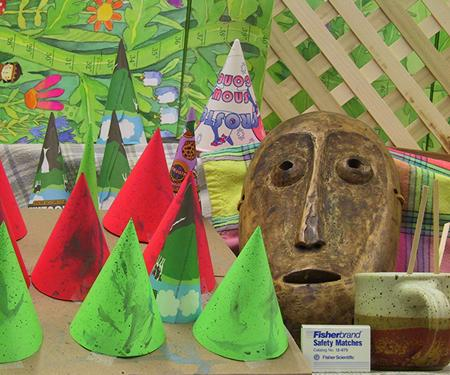
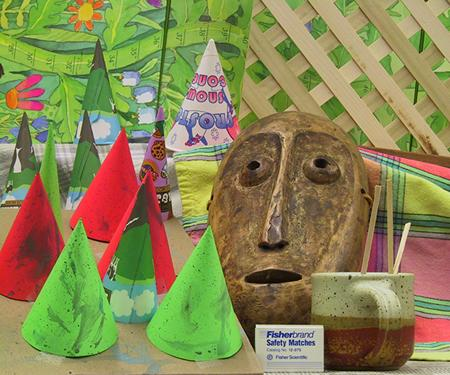

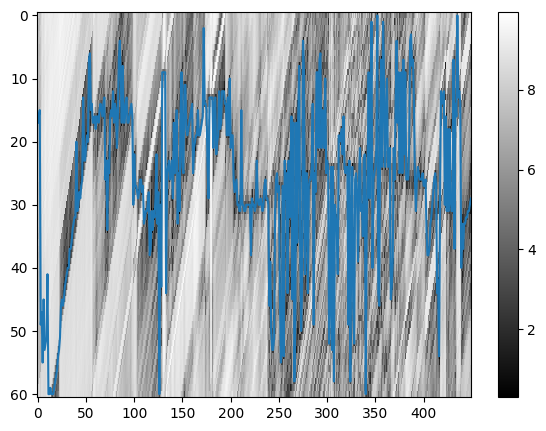

In [15]:
# read the images of the cones stereo pair
im1 = utils.readGTIFF('data/im2.png')
im2 = utils.readGTIFF('data/im6.png')
dmin = -60
dmax = 0

vistools.display_gallery([im1, im2])

# compute the cost volume
CV = stereo.costvolumeSD(im1, im2, dmin, dmax)

# display slice
vistools.display_imshow(np.log(1+CV[220, :, :].transpose()), cmap='gray', axis='tight', show=False)

# overprint WTA plot
df = np.argmin(CV[220, :, :], axis=1)
plt.plot(df)
plt.show()


In [16]:
def WTA(CV):
    """
    Compute the Winner Takes All (WTA) of the cost volume CV.

    Args:
        CV (np.array): 3D array containing a cost volume

    Return:
        2D array of disparity indices that minimise the cost volume
    """
    ### YOUR CODE HERE ###
    return np.argmin(CV, axis=2)


The code below calls the `stereo.costvolumeSD` function to compute the cost volume for the `cones` image pair. Then, it displays an (x, d) slice of the cost volume (in log intensity). Finally it computes and shows
the WTA disparity for the whole image.


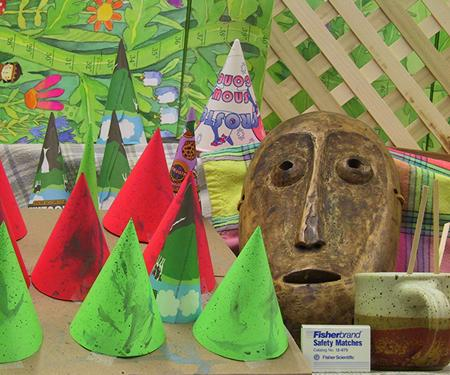
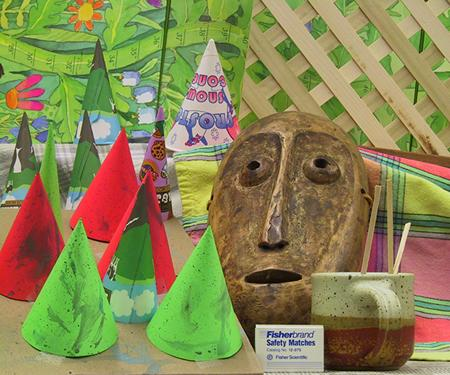

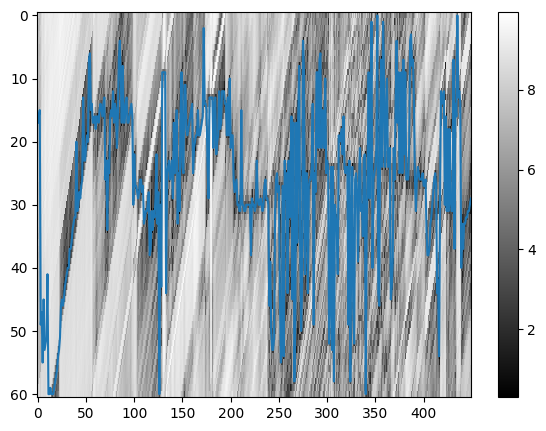

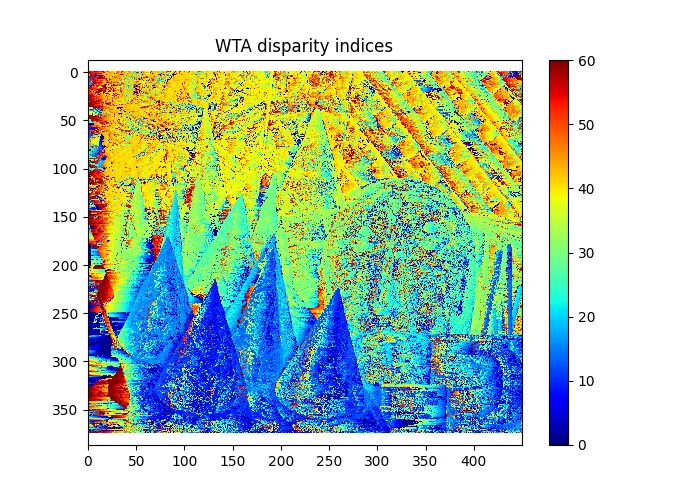

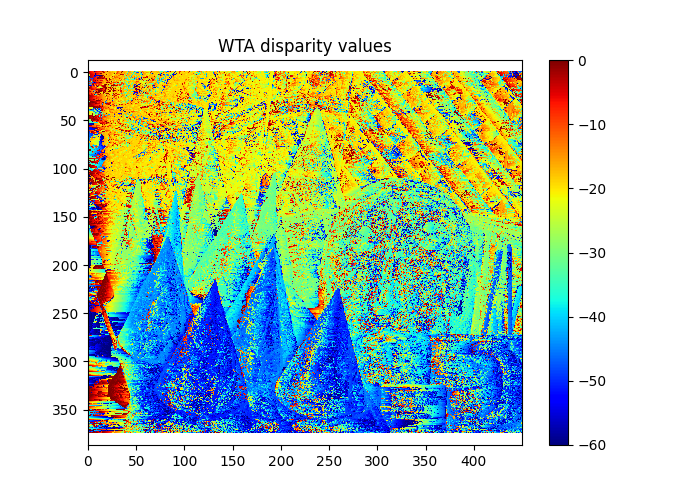

In [17]:
# read the images of the cones stereo pair
im1 = utils.readGTIFF('data/im2.png')
im2 = utils.readGTIFF('data/im6.png')
dmin = -60
dmax = 0

vistools.display_gallery([im1, im2])

# compute the cost volume
CV = stereo.costvolumeSD(im1, im2, dmin, dmax)

# display slice
vistools.display_imshow(np.log(1+CV[220, :, :].transpose()), cmap='gray', axis='tight', show=False)

# overprint WTA plot
df = np.argmin(CV[220, :, :], axis=1)
plt.plot(df)
plt.show()

# show WTA disparity index
vistools.display_imshow(WTA(CV)       , cmap='jet', title='WTA disparity indices', inline=True)

# and the corresponding WTA disparity value
vistools.display_imshow(WTA(CV) + dmin, cmap='jet', title='WTA disparity values', inline=True)

The fact that the disparity is spatially regular permits to improve the above result.
To do so we aggregate (i.e. **compute the mean**) of the costs on 2D windows (on the x, y plane).
Usually a small window of $5\times 5$ pixels suffices.
This process amounts to computing the SSD (sum of squared differences) cost.

We can also include a regularization in the `disparity` direction by difining a 3D window.

**Exercise 2.** Implement the `aggregateCV` function below. This function filters the cost volume with a rectangular spatial window of size `win_w * win_h * win_d` and uniform `weight = 1 / (win_w * win_h * win_d)`. The function returns the filtered cost volume.

**Hint:** Use `scipy.signal.convolve` to apply the convolution and set the parameter `mode='same'`.

In [20]:
def aggregateCV(CV, win_w, win_h, win_d=1):
    """
    Filter the cost volume with a 3D spatial-depth window of size
    win_w * win_h * win_d and uniform weights 1 / (win_w * win_h * win_d).

    Args:
        CV: numpy array containing the cost volume
        win_w, win_h, win_d (defaut=1): width, height and depth of the rectangular window

    Returns:
        numpy array containing the filtered cost volume
    """



    import scipy.signal
    K = np.ones((win_h, win_w, win_d)) / (win_w*win_h*win_d)
    CV = scipy.signal.convolve(CV, K, mode='same')
    return CV





The code below filters the cost volume produced in the previous exercise using your `aggregateCV` function.
Then, it displays an (x, d) slice of the cost volume (in log intensity) and shows the WTA disparity for the whole image.

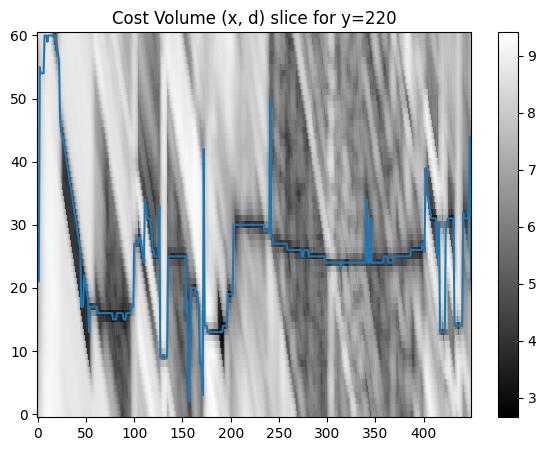

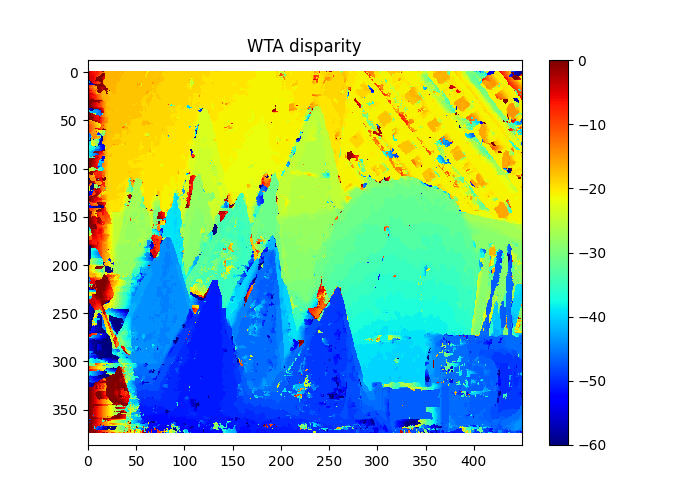

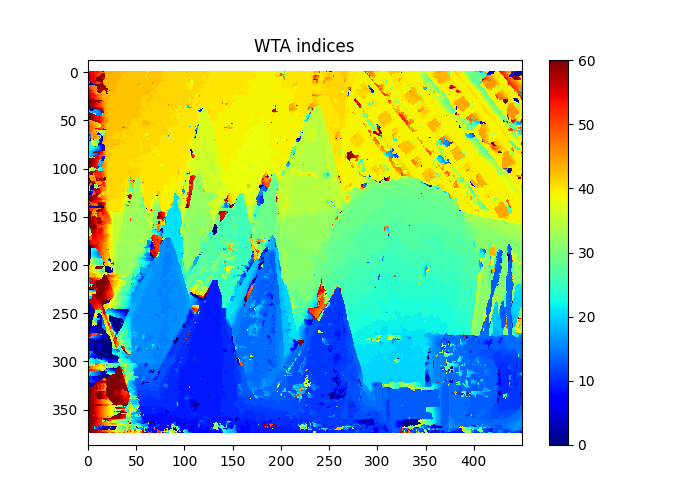

In [22]:
## Village
# im1 = utils.readGTIFF('data/village2a.png')
# im2 = utils.readGTIFF('data/village2b.png')
# dmin, dmax = -30, 30

# compute the SSD cost volume with 5x5 windows
CV = stereo.costvolumeSD(im1, im2, dmin, dmax)
CV = aggregateCV(CV, 5, 5)

# display slice
vistools.display_imshow(np.log(1+CV[220].transpose()), cmap="gray",
                        axis="tight", invert=True, show=False,
                        title="Cost Volume (x, d) slice for y=220")

# WTA plot
df = np.argmin(CV[220], axis=1)
plt.plot(df)
plt.show()

# show WTA disparity
vistools.display_imshow(WTA(CV)+dmin, cmap="jet", title="WTA disparity", inline=True)

vistools.display_imshow(WTA(CV), cmap="jet", title="WTA indices", inline=True)

# B. Census Transform

The big limitation of the SSD cost is that it is not robust  to illumination changes or artifacts. The Hamming distance between Census Transforms (CT) is a very robust matching cost. The function `stereo.costvolumeCT` computes the CT of the two images, then uses them to compute the cost volume.

The pair of satellite images `data/t0.tif`, `data/t1.tif` allow us to appreciate the robustness of CT. The objective of the following exercise is to compare the results obtained with the SD and CT cost volumes using the Cones image pair, and a pair of satellite images.

**Exercise 3.** Complete the `ssd_vs_census` function below.
The function produces the two disparity maps computed using the SD and CT costs.
The parameters `cw`, `win_w` and `win_h` should be set to obtain the "best" results for each cost.
The function displays the resulting disparity maps.

In [23]:
def ssd_vs_census(im1, im2, dmin, dmax):
    """
    Produce the "best" disparity maps we can get using SSD and CENSUS costs, aggregation, and WTA.

    Args:
        im1, im2: numpy arrays containing the stereo pair (im1 is reference)
        dmin, dmax: minimum and maximum disparity to be explored

    Returns:
        happyness for your eyes
    """
    # BEGIN SOLUTION
    win_w = 5
    win_h = 5
    cw = 7
    # END SOLUTION

    # SSD
    CV = stereo.costvolumeSD(im1, im2, dmin, dmax)
    CV = aggregateCV(CV, win_w, win_h)
    dSSD = WTA(CV)+dmin

    # CENSUS
    CV = stereo.costvolumeCT(im1, im2, dmin, dmax, cw)
    CV = aggregateCV(CV, win_w, win_h)
    dCT = WTA(CV)+dmin

    f, ax = plt.subplots(1, 2)

    ax[0].imshow(dSSD.squeeze(), cmap='jet')
    ax[1].imshow(dCT.squeeze(), cmap='jet')

The code below calls your function for the `cones` and `satellite` pairs and display the computed disparity maps.


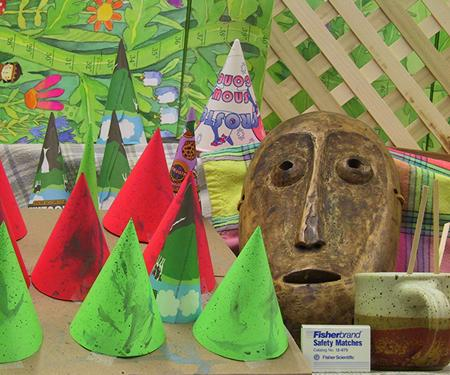
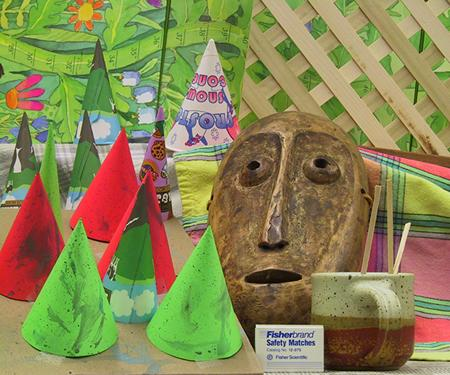


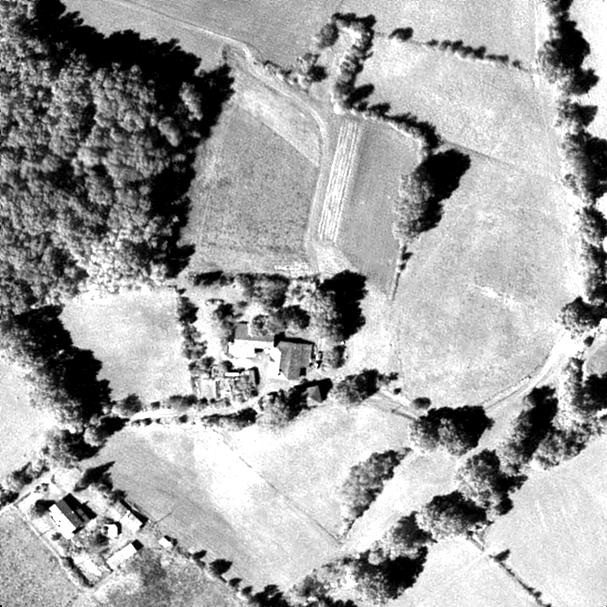
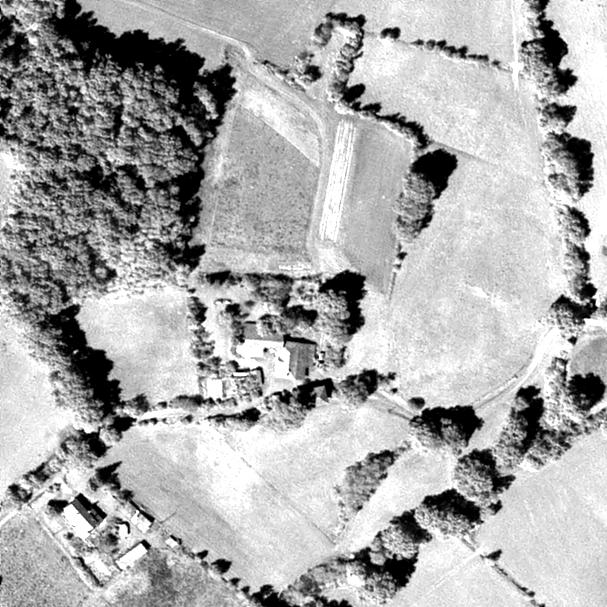

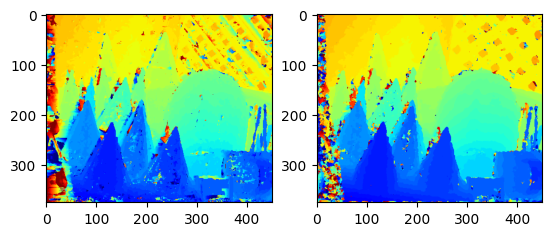

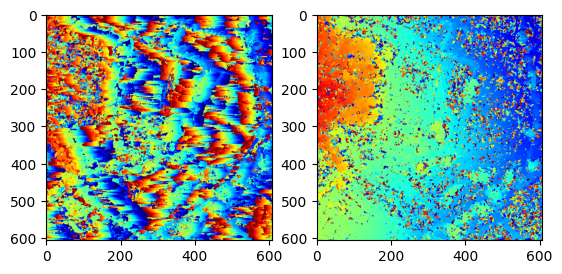

In [24]:
### load Cones pair ###
im1 = utils.readGTIFF('data/im2.png')
im2 = utils.readGTIFF('data/im6.png')
dmin, dmax = -60, 0
vistools.display_gallery([im1, im2])

# compute and display the disparity maps
ssd_vs_census(im1, im2, dmin, dmax)

### load Satellite pair ###
im1_sat = utils.readGTIFF('data/t0.tif')
im2_sat = utils.readGTIFF('data/t1.tif')
dmin_sat, dmax_sat = -30, 50
vistools.display_gallery([utils.simple_equalization_8bit(im1_sat),
                          utils.simple_equalization_8bit(im2_sat)])

# compute and display the disparity maps
ssd_vs_census(im1_sat, im2_sat, dmin_sat, dmax_sat)

# C. Mismatch filtering: Left-Right and Speckle

We can already put together our Block Matching algorithm (implemented below) `stereoBM(im1, im2, dmin, dmax, winh=5, winw=5, cost='sd', cw=5)` which given an image pair `im1`, `im2`, a disparity range, cost function, and a window size returns a disparity map.

To remove the spurious matches in the disparity map we shall use the left-right consistency test and specke filtering, which are two of the most effective filtering methods.
* The Left-Right Consistency test (to be implemented in function `leftright`) asks for the disparity maps computed from left-to-right and right-to-left to be inverse of each other. This verification imposes the uniqueness of the match. Let us denote by $L$ and $R$ the left and right images. Let $d_{L}$ be the disparity map from $L$ to $R$, that is $L(x) = R(x + d_{L}(x))$ and $d_{R}$ be the map from $R$ to $L$. The disparity at $x$ is **rejected** by the `leftright` test if
$$\lvert d_{R}([x + d_{L}(x)]) + d_{L}(x) \rvert > \tau,$$
where $[\cdot]$ is the rounding operator, and the threshold $\tau$ is usually set to 1 pixel.

*  The speckle filter (implemented in `stereo.specklefilter`) imposes the smoothness of the solution by removing  small connected disparity components that have a disparity inconsistent with their neighborhood.

**Exercise 4.** Complete the implementation of the `leftright` function below. The function applies the left-right consistency test. It returns the filtered disparity map where the rejected pixels are set to `np.inf`.

**Hint:** You may use the function `np.meshgrid` to generate two matrices with the `x` and `y` coordinates of all pixels of the disparity map.

In [25]:
def leftright(disp_L, disp_R, maxdiff=1):
    """
    Filter the left disparity map by applying the left-right consistency test.

        |disp_R(round(x + disp_L(x))) + disp_L(x)| <= maxdiff

    Args:
        disp_L, disp_R: numpy arrays containing the Left and Right disparity maps
        maxdiff: threshold for the uniqueness constraint

    Returns:
        numpy array containing the disp_L disparity map with rejected pixels set to np.inf
    """
    h, w = disp_L.shape
    x, y = np.meshgrid(range(w), range(h))

    ### YOUR CODE HERE ###
    # BEGIN SOLUTION
    # sanitize the disparity values
    xx = np.round(np.clip(x + disp_L, 0, w - 1)).astype(int)

    # apply the test
    m = np.abs(disp_R[y, xx] + disp_L) > maxdiff

    # the binary matrix m is the resulf of the consistency test.
    # here we use it to set the invalid pixels to infinity
    out = disp_L.copy()
    out[m] = np.inf
    return out
    # END SOLUTION

The cell below uses  your `leftright` function  to filter the disparity maps computed with `stereoBM`.

t=0.8885 done building CV
t=3.9801 done aggregating CV
t=0.6760 done building CV
t=3.6784 done aggregating CV


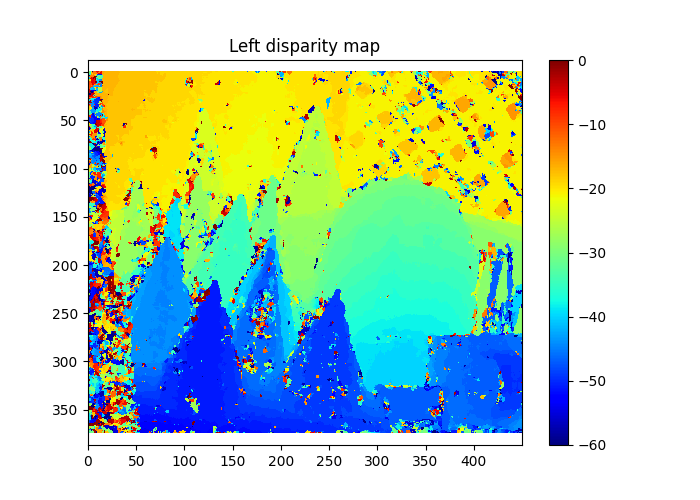

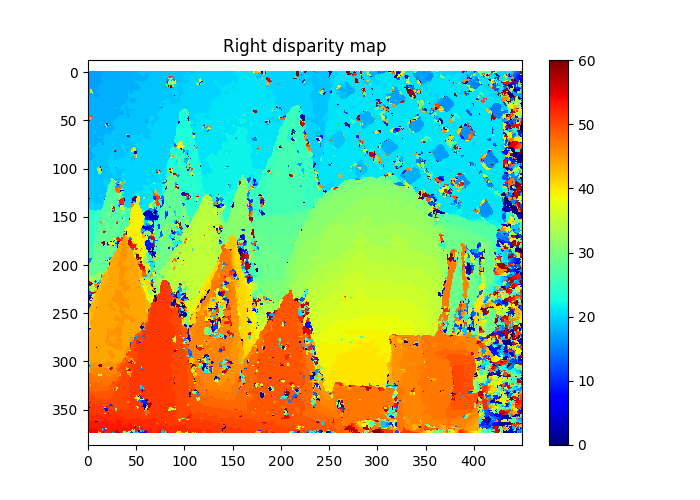

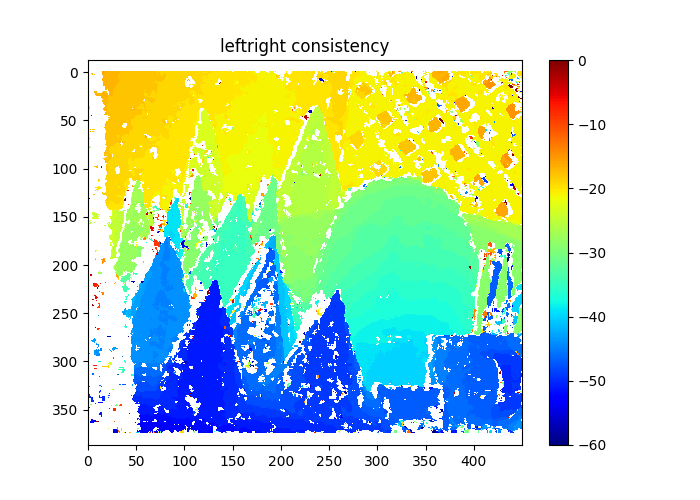

CPU times: user 2.68 s, sys: 91.1 ms, total: 2.77 s
Wall time: 3.01 s


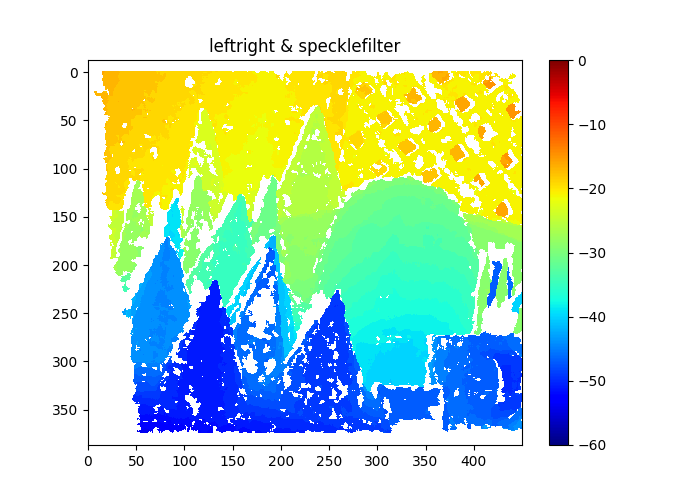

In [26]:
def stereoBM(im1, im2, dmin, dmax, winh=5, winw=5, cost='sd', cw=5, subpix_refine=False):
    """
    Compute the disparity map from im1 to im2 using block matching with SSD and CENSUS costs.

    Args:
        im1, im2: numpy arrays containing the stereo pair (im1 is reference)
        dmin, dmax (ints): minimum and maximum disparity to be explored
        winh, winw (ints): aggregation window size (set to 1 to disable)
        cost (str): type of cost volume can be: 'sd' or 'census'
        cw (int): census window size, used when cost='census'
        subpix_refine (bool): activates the Vfit subpixel refinement (default False)

    Returns:
        numpy array containing the disparity map

    """
    import time
    start_time = time.time()

    # create cost volume
    if cost == 'sd':
        CV = stereo.costvolumeSD(im1, im2, dmin, dmax)
    else:
        CV = stereo.costvolumeCT(im1, im2, dmin, dmax, cw)
    print('t={:2.4f} done building CV'.format(time.time() - start_time))

    # aggregate
    CV = aggregateCV(CV, winh, winw)
    print('t={:2.4f} done aggregating CV'.format(time.time() - start_time))

    # WTA
    if subpix_refine:
        d, _ = stereo.VfitWTA(CV, np.nanargmin(CV, axis=2).astype(np.float32),
                              np.nanmin(CV, axis=2).astype(np.float32))
    else:
        d = WTA(CV).astype(np.float32)

    # map from disparity index to disparity value and return
    return d + dmin


## Let's reload the Cone images just in case
im1 = utils.readGTIFF('data/im2.png')[:, :, 0]
im2 = utils.readGTIFF('data/im6.png')[:, :, 0]
dmin = -60
dmax = 0

# compute left and right dispariy maps
win = 5
dL = stereoBM(im1, im2, dmin, dmax, win, win, cost='census')
dR = stereoBM(im2, im1, -dmax, -dmin, win, win, cost='census')
vistools.display_imshow(dL, cmap='jet', range=[dmin, dmax], title="Left disparity map", inline=True)
vistools.display_imshow(dR, cmap='jet', range=[-dmax, -dmin], title="Right disparity map", inline=True)

# left-right
dLR = leftright(dL, dR, 1)
vistools.display_imshow(dLR, cmap='jet', range=[dmin, dmax], title="leftright consistency", inline=True)

# speckle
%time dLRspeckle = stereo.specklefilter(dLR, area=50, th=1)
vistools.display_imshow(dLRspeckle, cmap='jet', range=[dmin, dmax], title="leftright & specklefilter", inline=True)

Finally let's define a shorthand function for applying these filters

In [28]:
def mismatchFiltering(dL, dR, area=50, tau=1):
    """
    Apply left-right and speckle filters.

    Args:
        dL, dR (np.array): left and right disparity maps
        area (int): minimum area parameter of the speckle filter
        tau (int): maximum left-right disparity difference

    Returns:
        array containing a filtered version of the left disparity map, with rejected pixels set to infinity
    """
    dLR = leftright(dL, dR, tau)
    dLRspeckle = stereo.specklefilter(dLR, area=area, th=1)
    return dLRspeckle

# D. 1D Cost Volume Filtering with Dynamic Programming

Spatial regularity of the disparity map $D$ can be imposed by minimizing an energy along scanlines:

$$ E(D) = \sum_p C_p(D_p) + \lambda \sum_p \lvert D_p - D_{p+1}\rvert $$

where $C$ is the cost volume and $p$ denotes the coordinates of a pixel along the scanline.

Instead of just computing the optimal path, or labeling, $D$ (using the classic Viterbi algorithm), we shall implement a **forward-backward** algorithm, which computes the min-marginals at each pixel and for each disparity value. The optimal path is then extracted by point-wise WTA.

First, we must implement a left-to-right Viterbi filtering `filterViterbi` (without backtracking) which solves the sequence of problems
$$ L_+(p,d) = \min_{D_1,\dots  D_{p-1}} \sum_{q=1}^{p} C_q(D_q) + \lambda \sum_{q=1}^{p-1} V(D_q, D_{q+1}) \quad \text{s.t.}\quad D_p = d, $$
and use it twice in the provided function `filterfwbw` to compute the min-marginals as in equation (17) of the notes
$$S_p(d) = L_+(p,d) + L_-(p,d) - C_p(d)$$

**Exercise 5.**  Complete the implementation of the `filterViterbi` function below.
The function filters the cost volume $C$ by computing
$$L_+(p,d) = C_{p}(d) + \min_{d'}(L_+(p-1, d') + \lambda V (d, d')),$$
and returns a numpy array containing the filtered costvolume.

**Don't Panic** about efficiency while coding filterViterbi. After
debugging we can accelerate it using the `numba.jit` compiler.

<font color="red">**Also answer to this Question.**</font> What is the complexity of filterViterbi with respect to the number
of pixels M and the number of disparities L?

In [33]:
line= CV[220]
line.shape

(450, 61)

In [35]:
def filterViterbi(c, lam=8):
    """
    Filter the cost volume by computing
       L_+(p, d) =  C_{p}(d) + \min_{d'}(L_+(p-1, d') +  \lambda V(d, d'))
       with   V(x, y) = |x - y|

    Args:
        cv: numpy array of shape [nodes M, disparities L] containing a cost volume slice
        lam: lambda parameter of the energy

    Returns:
        numpy array containing the filtered costvolume slice
    """
    sh = c.shape
    num_nodes = sh[0]
    num_disp  = sh[1]

    L = c.copy().astype(np.float64)
    for p in range(1, num_nodes): # loop over the nodes

        # compute min path for each label of node i
        for d in range(num_disp):
            minL = np.inf
            Cpd= c[p, d]
            for dp in (d-1, d, d+1):
                if dp >= 0 and dp < num_disp:
                    minL= min(minL, L[p-1, dp] + lam * np.abs(d-dp))
            L[p, d] += minL


            ### YOUR CODE HERE ###


    return L


>>> WRITE YOUR ANSWER TO THE QUESTION HERE <<<

The code below defines the `filterfwbw` using your `filterViterbi` then applies it on line 220 of the SD cost volume (for the Cone pair).

CPU times: user 595 ms, sys: 17.2 ms, total: 612 ms
Wall time: 616 ms


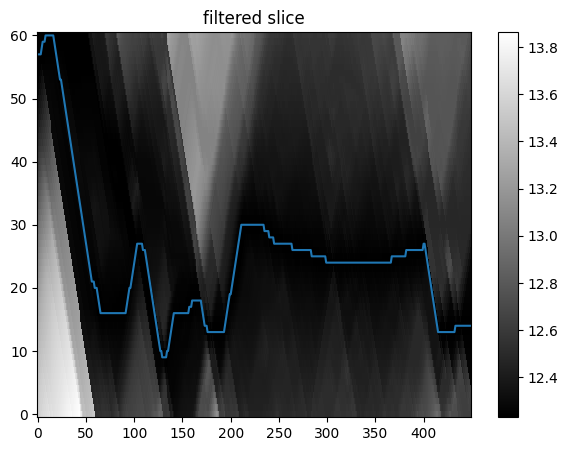

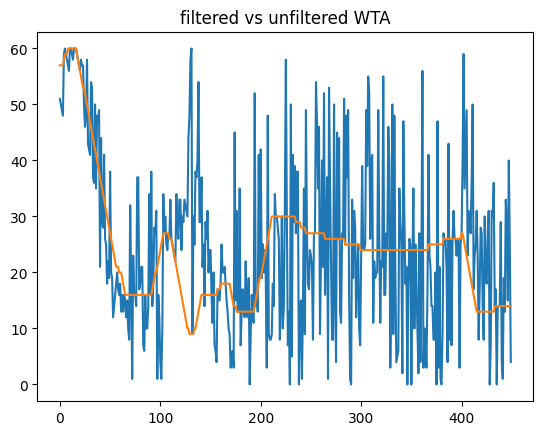

In [36]:
from numba import jit

# compile the filterViterbi function with numba.jit
#Viterbi = filterViterbi  # for DEBUGGING
Viterbi = jit(filterViterbi,nopython=True)


def filterfwbw(c, lam=8):
    Viterbi = jit(filterViterbi,nopython=True)

    fw = Viterbi(c[::1, :], lam=lam)
    bw = Viterbi(c[::-1, :], lam=lam)
    return fw + bw[::-1] - c[::1, :]


### Let's reload the Cone pair just in case
im1 = utils.readGTIFF('data/im2.png')[:, :, 0]
im2 = utils.readGTIFF('data/im6.png')[:, :, 0]
dmin = -60
dmax = 0

# compute the SD costvolume and extract the slice at line 220
CV = stereo.costvolumeSD(im1, im2, dmin, dmax)
line = CV[220]

# filter the slice
# The lambda parameter depends on the range of values in the cost volume
%time fline = filterfwbw(line, lam=1000)

# display the slice
vistools.display_imshow(np.log(1+fline.transpose()) , cmap='gray', axis='tight',
                        invert=True, show=False, title="filtered slice")
# overprint the WTA solution on top of the costvolume
d = np.argmin(line, axis=1)
df = np.argmin(fline, axis=1)
plt.plot(df)
plt.show()

# compare the WTA on the unfiltered costvolume with the filtered one
plt.figure()
plt.plot(d)
plt.plot(df)
plt.title("filtered vs unfiltered WTA")
plt.show()

**Exercise 6.**  Complete the `filterViterbiV` function below.
The function filters the cost volume $C$ by computing
$$L_+(p,d) =  C_{p}(d) + \min_{d'}(L_+(p-1,d') +  \lambda V (d, d')) \quad \text{with}  \quad
V(d,d')  =
\left\{
\begin{array}{ll}
  0    &\text{if } d  = d'  \\
  P1  &\text{if }  |d - d'|=1 \\
  P2  &\text{otherwise}
\end{array}
\right.,
$$
where the regularizer  parameters are set to $P1=1$ and $P2=4$.
The function must return a numpy array containing the filtered costvolume slice.


<font color="red">**Also answer to this Question.**</font> What is the complexity of `filterViterbiV` with respect to the number
of pixels M and the number of disparities L?

In [37]:
def filterViterbiV(c, lam=8):
    """
    The function filters the cost volume by computing
       L_+(p, d) = C_{p}(d) + \min_{d'}(L_+(p-1,d') + \lambda V(d, d'))
                       | 0 , if  x=y
       with   V(x,y) = | P1, if |x-y|=1
                       | P2, otherwise
    and parameters P1=1 and P2=4.

    Args:
        cv: numpy array of shape [nodes M, disparities L] containing a cost volume slice
        lam: lambda parameter of the energy

    Returns:
        numpy array containing the filtered costvolume slice
    """
    P1 = 1.0
    P2 = 4.0
    sh = c.shape
    num_nodes = sh[0]
    num_disp  = sh[1]

    L = c.copy().astype(np.float64)

    for p in range(1, num_nodes): # loop over the nodes

        minLim1 = np.min(L[p-1, :])  # precompute min of the previous node

        # BEGIN SOLUTION
        for d in range(num_disp):       # loop over the disparities
            minL = lam * P2 + minLim1   # minLim1=0 when the previous node has been normalized
            for dp in (d-1, d, d+1):
                if dp >= 0 and dp < num_nodes:
                    newL = L[p-1, dp] + lam * P1 * np.abs(d-dp)
                    if minL > newL:
                        minL = newL
            L[p, d] += minL

        # this normalization removes the min of the previous node
        L[p, :] = L[p, :] - np.min(L[p, :])  # normalize (keeps values from growing too much)
        # END SOLUTION

    return L

>>> WRITE YOUR ANSWER TO THE QUESTION HERE <<<

The code below defines the `filterVfwbw` which applies your `filterViterbiV`
twice to  compute the min-marginals as in equation (17) of the notes.
Then applies it on line 220 of the SD cost volume (for the Cone pair).

CPU times: user 2.27 s, sys: 194 ms, total: 2.46 s
Wall time: 2.45 s



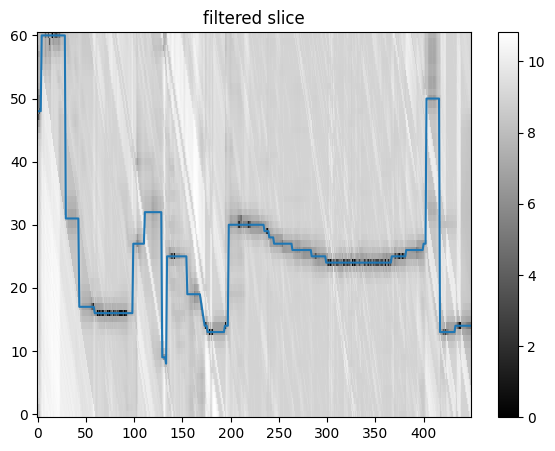

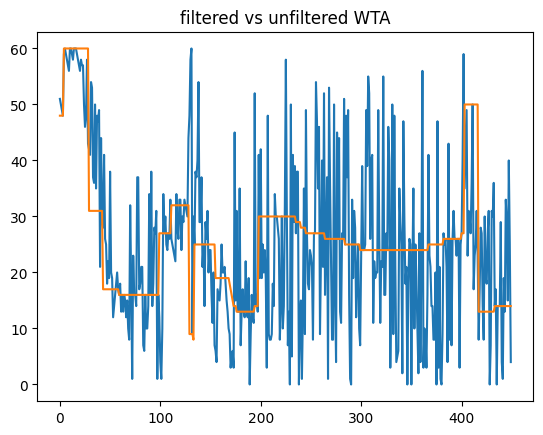

In [38]:
from numba import jit

# compile the filterViterbi function with numba.jit
# Viterbi = filterViterbi  # for DEBUGGING
ViterbiV = jit(filterViterbiV,nopython=True)


def filterVfwbw(c, lam=8):
    fw = ViterbiV(c[::1, :], lam=lam)
    bw = ViterbiV(c[::-1, :], lam=lam)
    return fw + bw[::-1] - c[::1, :]


### Let's reload the Cone pair just in case
im1 = utils.readGTIFF('data/im2.png')[:, :, 0]
im2 = utils.readGTIFF('data/im6.png')[:, :, 0]
dmin = -60
dmax = 0

# compute the SD costvolume and extract the slice at line 220
CV = stereo.costvolumeSD(im1, im2, dmin, dmax)
line = CV[220]

# filter the slice
# The lambda parameter depends on the range of values in the cost volume
%time fline = filterVfwbw(line, lam=1000)

# display the slice
print()
vistools.display_imshow(np.log(1+np.abs(fline.transpose())), cmap='gray', axis='tight',
                        invert=True, show=False, title="filtered slice")
# overprint the WTA solution on top of the costvolume
d = np.argmin(line, axis=1)
df = np.argmin(fline, axis=1)
plt.plot(df)
plt.show()

# compare the WTA on the unfiltered costvolume with the filtered one
plt.figure()
plt.plot(d)
plt.plot(df)
plt.title("filtered vs unfiltered WTA")
plt.show()

Now let's assemble a scanline optimization algorithm in the function  `scanlinefilter` below by applying `filterVfwbw`, or your `filterViterbiV` twice, to all the scanlines of the image.

In [39]:
def scanlinefilter(CV, lam=8):
    """
    Scanline cost volume filtering using the forward-backward algorithm
    using the truncated regularity term V (with parameters P1=1, P2=4)

    Args:
        CV: numpy array of size [width, height, disparity] containing the costvolume
        lam: lambda regularity parameter

    Returns:
        numpy array containing the filtered costvolume
    """
    ViterbiV = jit(filterViterbiV,nopython=True)

    S = np.zeros(CV.shape)
    for i in range(CV.shape[0]):
        fw = ViterbiV(CV[i, :, :], lam=lam)
        bw = ViterbiV(CV[i, ::-1, :], lam=lam)
        S[i, :, :] = fw + bw[::-1] - CV[i, :, :]
    return S

The code block below calls `scanlinefilter` and shows the WTA result for the cones image.

**Exercise 7.** Adjust the value of the regularity parameter (lambda) in the code below to obtain a good result for the SD cost volumes.

CPU times: user 1.56 s, sys: 84.9 ms, total: 1.65 s
Wall time: 1.64 s


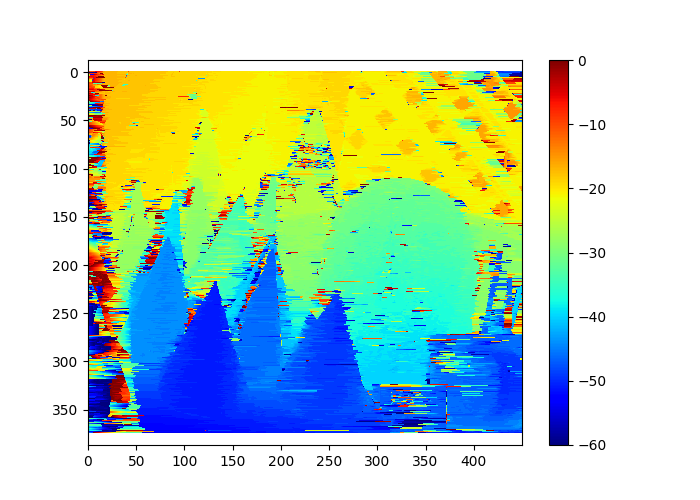

In [40]:
CV = stereo.costvolumeSD(im1, im2, dmin, dmax)

THE_GOOD_LAMBDA = 1  ### CHANGE THIS TO GET A GOOD RESULT
# BEGIN SOLUTION
THE_GOOD_LAMBDA = 100
# END SOLUTION

# call scanlinefilter using the GOOD LAMBDA
%time CV = scanlinefilter(CV, lam=THE_GOOD_LAMBDA)
vistools.display_imshow(WTA(CV)+dmin, cmap='jet', inline=True)

As expected the result contains streaking artifacts because the scanlines are filtered independently.
One way to remove the streaking artifacts is by post processing the cost volume
with `aggregateCV` and then computing the WTA. Observe the results.

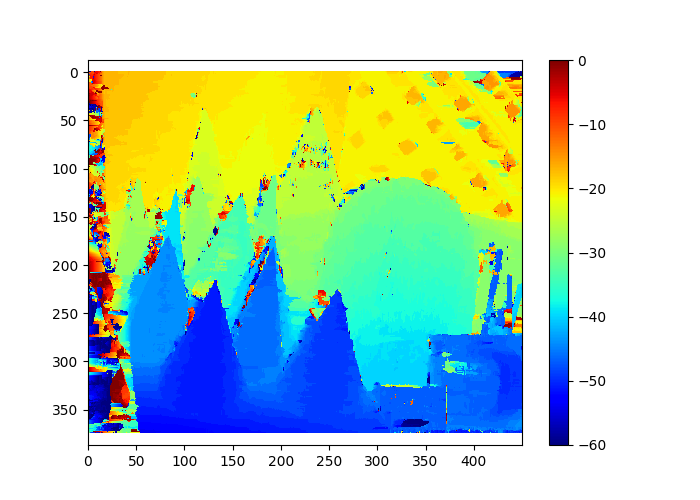

In [41]:
# remove horizontal streaking artifacts by convolving with a vertical filter
CV = aggregateCV(CV, 1, 5)
vistools.display_imshow(WTA(CV)+dmin, cmap='jet', inline=True)

# E. Semi Global Matching


In light of the previous result the next logical step would be to filter the cost volume along columns using dynamic programming too!  This is what SGM does, but it also includes diagonal filtering directions.

<img src="https://qph.cf2.quoracdn.net/main-qimg-d8a62c27572f4d472d61e6300b87eeb5-lq" alt="Logic" width="150px"/>


**Exercise 8.** Complete the `sgmfilter` function below.
The function is similar to `scanlinefilter` and includes the filtering along the columns.
This corresponds to a 4-direction SGM.
The function must return the filtered cost volume.

In [ ]:
def sgmfilter(CV, lam=8):
    """
    SGM cost volume filtering along 4 directions
    using the truncated regularity term V (with parameters P1=1, P2=4)

    Args:
        CV: numpy array of size [width, height, disparity] containing the costvolume
        lam: lambda regularity parameter

    Returns:
        numpy array containing the filtered costvolume
    """
    # compile the filterViterbiV function
    ViterbiV = jit(filterViterbiV,nopython=True)

    S = np.zeros(CV.shape)

    for i in range(CV.shape[0]):
        fw = ViterbiV(CV[i, :, :], lam)
        bw = ViterbiV(CV[i, ::-1, :], lam)
        S[i, :, :] += fw + bw[::-1]

    for i in range(CV.shape[1]):

        pass
        ### YOUR CODE HERE ###


    return S - 3*CV

The code below calls your `sgmfilter` function and applies it on the cones stereo pair.

In [ ]:
CV = stereo.costvolumeSD(im1, im2, dmin, dmax)

# do 4-sgm
%time CV = sgmfilter(CV, 300)       # SGM
d = WTA(CV)                         # WTA

if 0:               # optional 3x3 median filter
    import scipy
    d = scipy.signal.medfilt(d, kernel_size=(3, 3))

vistools.display_imshow(d+dmin, cmap='jet', inline=True)

## Wrap up SGM

We can now write the function `stereoSGM`, analogous to `stereoBM`.

In [ ]:
def stereoSGM(im1, im2, dmin, dmax, lam=10, cost='census', cw=3, win=1, subpix_refine=False):
    """
    Compute the disparity map from im1 to im2 using SGM.

    Args:
        im1, im2: numpy arrays containing the stereo pair (im1 is reference)
        dmin, dmax: minimum and maximum disparity to be explored
        lam:
        cost: type of cost volume can be: 'sd' or 'census'
        cw:  census window size, used when cost='census'
        win: size of the square window with which the cost volume is filtered (set to 1 to disable)
        subpix_refine: activates the Vfit subpixel refinement (default False)

    Returns:
        numpy array containing the disparity map
    """
    import time
    start_time = time.time()

    # generate the cost volume
    if cost=='sd':
        CV=stereo.costvolumeSD(im1, im2, dmin, dmax)
    else:
        CV=stereo.costvolumeCT(im1, im2, dmin, dmax, cw=cw)

    print ('t={:2.4f} done building CV'.format(time.time() - start_time))
    CV = sgmfilter(CV,lam)         # SGM

    print ('t={:2.4f} done sgmfilter'.format(time.time() - start_time))

    CV = aggregateCV(CV,win,win)

    # WTA
    if subpix_refine:
        d,_ = stereo.VfitWTA(CV, np.nanargmin(CV,axis=2).astype(np.float32), np.nanmin(CV,axis=2).astype(np.float32))
    else:
        d = stereo.WTA(CV).astype(np.float32)

    # map from disparity index to disparity value and return
    return d+dmin

The code below applies the function `stereoSGM` to the satellite stereo pair `data/t0.tif`, `data/t1.tif` and then applies the `mismatchFiltering`.

**Note:** from now on we are using the Census cost as the default matching cost.

**Note 2:** the regularity parameter $\lambda$ and the size of the census window `cw` may require some tweaking.

In [ ]:
# im1 = utils.readGTIFF('data/im2.png')[:, :, 0]
# im2 = utils.readGTIFF('data/im6.png')[:, :, 0]
# dmin = -60
# dmax = 0

# im1_sat = utils.readGTIFF('data/rectified_ref.tif')[:, :, 0]
# im2_sat = utils.readGTIFF('data/rectified_sec.tif')[:, :, 0]
# dmin_sat, dmax_sat = -150, 100

im1_sat = utils.readGTIFF('data/t0.tif')[:, :, 0]
im2_sat = utils.readGTIFF('data/t1.tif')[:, :, 0]
dmin_sat, dmax_sat = -30, 50

# compute left and right disparity maps
dL = stereoSGM(im1_sat, im2_sat, dmin_sat, dmax_sat, lam=20, cost='census', cw=7, win=3)
dR = stereoSGM(im2_sat, im1_sat, -dmax_sat, -dmin_sat, lam=20, cost='census', cw=7, win=3)

# apply mismatch filtering
LRS = mismatchFiltering(dL, dR, 50)

# display the result
vistools.display_imshow(LRS, cmap='jet', inline=True)

In [ ]:
vistools.display_imshow(dR, cmap='jet', inline=True)

# F. Randomized Search and Patchmatch


The simplified patchmatch algorithm described in the notes consists of iterating two main steps:
* random disparity search `randpass`,
* disparity propagation (forward and backward) `fwpass` and `bwpass`.

Each step updates the current disparity by proposing new disparities at each pixel,
which are retained if they yield a lower matching cost.

Our patchmatch implementation only works with the census distance (Hamming of census transformed images).

We will start implementing a randomized disparity search algorithm (`randmatch`).
A key component of this algorithm is the function `randpass` proposed in the block below.

**Exercise 9.** Complete the implementation of the `randpass` function.
This function updates the current disparity map by randomly sampling new disparities for each pixel,
and updating the  disparity and minimum cost if the cost is lower than the current one.
The function receives the current offset and cost associated to each pixel as well as the new proposed offset.
It must update the costs and offsets if appropriate and return them.

**Hint:** Use the function `computeHamming(im1, im2, i, j, k, l)`
to efficiently compute the matching cost (Hamming distance)
between the position `im1[i, j]` and `im2[k, l]`.
The function will be compiled

In [ ]:
@jit   ###  You can commet this line for debugging
def randpass(off, cost, randoff, im1, im2):
    '''
    This function updates the current disparity map by randomly sampling new disparities for each pixel
    and updating the  disparity and minimum cost if the cost is lower than the current one.

    Args:
        im1,im2: numpy arrays containing the census transformed images of the pair
        off and cost: are numpy arrays containing the current offsets (or disparities) and costs for each pixel.
        randoff: is a set of new offsets to be tested for each pixel

    Returns:
        numpy two arrays containing the disparity map and
        the minimum matching costs at each pixel
    '''
    H,W,C = im1.shape


    for i in range(H):
        for j in range(W):
            newoff = randoff[i,j]
            if j+newoff >= 0 and j+newoff < W:

                newcost = stereo.computeHamming(im1,im2,i,j,i,j+newoff)

                ### YOUR CODE HERE ###

                # BEGIN SOLUTION
                if newcost < cost[i,j]:
                    off[i,j]  = newoff
                    cost[i,j] = newcost

                #END SOLUTION

    return off, cost

The code below defines and tests the `randmatch` algorithm (which uses your `randpass` function).
The algorithm will run 100 iterations, hence 100 disparities per pixel will be sampled.

**The input images are cropped to facilitate the debugging of the `randpass` function. When  compiled with @jit you can remove the crop.**

In [ ]:
def randmatch (im1,im2,dmin,dmax,cw=7,it=5):
    '''
    computes the disparity map from im1 to im2 by randomly
    sampling disparities and using the census cost

    Args:
        im1,im2: numpy arrays containing the stereo pair (im1 is reference)
        dmin,dmax: minimum and maximum disparity to be explored
        cw: census window size, used when cost='census'
        it: number or random sampling iterations
    Returns:
        numpy two arrays containing the disparity map and
        the minimum matching costs at each pixel
    '''
    import time
    start_time = time.time()

    # apply census transform to both images
    im1 = stereo.censustransform(im1,cw)
    im2 = stereo.censustransform(im2,cw)
    if im1.ndim == 2:   # computeHamming expects 3 dimensions
        im1 = np.expand_dims(im1,2)
        im2 = np.expand_dims(im2,2)
    print ('t={:2.4f} done computing transforms {}, '.format(time.time() - start_time, im1.shape))

    H,W,C = im1.shape
    off    = np.zeros((H,W),dtype=np.float64)
    cost   = np.zeros((H,W),dtype=np.float64) + np.Infinity

    # do random search iterating it times
    for it in range(it):
        newoff = np.random.randint(dmin,dmax,size=(H,W))
        off, cost = randpass(off,cost,newoff,im1, im2)
        # ###
        # ###
    print ('t={:2.4f} done running patchmatch {}, '.format(time.time() - start_time, im1.shape))

    return off, cost


# We're using a smaller image for debugging in case of no @jit
# remove the 100 to get the full image
im1 = utils.readGTIFF('data/im2.png')[:,:100,0]
im2 = utils.readGTIFF('data/im6.png')[:,:100,0]
dmin,dmax = -60, 0

off,cost = randmatch(im1,im2,dmin, dmax,it=100)

vistools.display_imshow(off, cmap='jet',range=[dmin,dmax], inline=True)

To complete the `patchmatch` implementation we only need to implement the forward and backward propagation functions `fwpass` and `bwpass`.

In [ ]:
@jit
def fwbwpass(off,cost, im1,im2,  backward=False):
    '''
    These function updates the current disparity map (off) by propagating the disparities in lexicogaphic
    and inverse lexicographic order respectively. This is done by testing the offsets of the
    two neighboring nodes (up and left for lexicographic order) at the current pixel
    and updating the  disparity and minimum cost if the cost is lower than the current one.

    Args:
        im1,im2: numpy arrays containing the census transformed images of the pair
        off and cost: are numpy arrays containing the current offsets (or disparities) and costs for each pixel.
        randoff: is a set of new offsets to be tested for each pixel
        backward: boolean that switchs to backward pass

    Returns:
        numpy two arrays containing the disparity map and
        the minimum matching costs at each pixel
    '''
    H,W,C = im1.shape

    # configure the traversals
    sx, ex, dd = 1,W,1
    sy, ey, dd = 1,H,1

    if backward:
        sx, ex, dd = W-2,-1,-1
        sy, ey, dd = H-2,-1,-1

    for i in range(sy,ey,dd):
        for j in range(sx,ex,dd):
            for newoff in (off[i-dd,j], off[i,j-dd]):
                if j+newoff >= 0 and j+newoff < W:
                    newc = stereo.computeHamming(im1,im2,i,j,i,j+newoff)
                    if newc < cost[i,j]:
                        off[i,j]  = newoff
                        cost[i,j] = newc
    return off,cost


## @jit
def fwpass(off,cost, im1,im2):
    '''
    see  fwbwpass
    '''
    return fwbwpass(off,cost, im1,im2,  False)


## @jit
def bwpass(off,cost, im1,im2):
    '''
    see  fwbwpass
    '''
    return fwbwpass(off,cost, im1,im2,  True)

**Exercise 10.** Complete the `patchmatch` implementation below by calling in the right place the `fwpass` and `bwpass` functions.

In [ ]:
def patchmatch (im1,im2,dmin,dmax,cw=7,it=5):
    '''
    computes the disparity map from im1 to im2 using the patchmatch
    algorithm using the census cost

    Args:
        im1,im2: numpy arrays containing the stereo pair (im1 is reference)
        dmin,dmax: minimum and maximum disparity to be explored
        cw: census window size, used when cost='census'
        it: iterations of the patchmatch algorithm
    Returns:
        numpy two arrays containing the disparity map and
        the minimum matching costs at each pixel
    '''
    import time
    start_time = time.time()

    im1 = stereo.censustransform(im1,cw)
    im2 = stereo.censustransform(im2,cw)
    if im1.ndim == 2:   # stereo.computeHamming expects 3 dimensions
        im1 = np.expand_dims(im1,2)
        im2 = np.expand_dims(im2,2)
    print ('t={:2.4f} done computing transforms {}, '.format(time.time() - start_time, im1.shape))

    H,W,C = im1.shape
    off    = np.zeros((H,W),dtype=np.float64)
    cost   = np.zeros((H,W),dtype=np.float64) + np.Infinity

    # iterate it times
    for it in range(it):
        newoff = np.random.randint(dmin,dmax,size=(H,W))
        off, cost = randpass(off,cost,newoff,im1, im2)


        ### YOUR CODE HERE ###


    print ('t={:2.4f} done running patchmatch {}, '.format(time.time() - start_time, im1.shape))
    return off, cost

The code below tests the `patchmatch` algorithm (which uses your `fwpass` and `bwpass` functions).
The algorithm will run 3 iterations, sampling about 15 disparities per pixel.
The resulting disparities are then filtered applying the `mismatchFiltering` function.

In [ ]:
#im1 = utils.readGTIFF('data/rectified_ref.tif')[:,:,0]
#im2 = utils.readGTIFF('data/rectified_sec.tif')[:,:,0]
#dmin,dmax=-100,150

im1 = utils.readGTIFF('data/im2.png')#[:,:,0]
im2 = utils.readGTIFF('data/im6.png')#[:,:,0]
dmin,dmax = -60, 0

# compute left and right disparity maps
off,cost = patchmatch(im1,im2,dmin,dmax,11,3)
offR,costR = patchmatch(im2,im1,-dmax,-dmin,11,3)

# apply mismatch filtering
LRS = mismatchFiltering(off, offR, 50, 3)
# display result
vistools.display_imshow(off, cmap='jet',range=[dmin,dmax], title='left patchmatch disparity', inline=True)
vistools.display_imshow(offR, cmap='jet',range=[-dmax,-dmin], title='right patchmatch disparity', inline=True)
print('Left-right consistent matches')
vistools.display_imshow(LRS, cmap='jet',range=[dmin,dmax], title='filtered mismatches patchmatch disparity', inline=True)

# G. Connecting the dots with the previous session

Now let's compute the disparity map for a rectified stereo pair produced in the the TP-rectification.

We first select the images and set the coordinates of the aoi.
Then use the function `rectify.rectify_aoi` to generate the rectified crops to be passed to the stereo matching algorithms.

In [ ]:
# list of tiff images available in the remote folder
images = utils.find('http://menthe.ovh.hw.ipol.im/IARPA_data/cloud_optimized_geotif/', 'TIF')
# sort the images by acquisition date
images.sort(key=utils.acquisition_date)


# create a map
m = vistools.clickablemap()

# select two image indices
i, j = 37, 38

# display the footprint polygons
for k in [i, j]:
    footprint = utils.lon_lat_image_footprint(images[k])
    m.add_layer(ipyleaflet.GeoJSON(data=footprint))

# center the map on the center of the last footprint
m.center = np.mean(footprint['coordinates'][0][:4], axis=0).tolist()[::-1]
display(m)

Draw a (small) area of interest (AOI) within the images footprints on the image above. Then click on the "Export" button. This triggers the download of a file named `data.geojson` containing the definition of your AOI. Copy the content of this file and paste it in the cell below to define the variable `geojson_content`.

If you don't, the default polygon defined in the next cell will be used.

In [ ]:
try:  # get coordinates of last AOI drawn on the map
    aoi = m.AOIs[-1]

except IndexError:  # predefined polygon on Buenos Aires if nothing was drawn
    print("Failed geojson parsing. Using default AOI.")
    aoi = {'type': 'Polygon',
           'coordinates': [[[-58.584587, -34.490861],
                            [-58.584587, -34.489077],
                            [-58.58301,  -34.489077],
                            [-58.58301,  -34.490861],
                            [-58.584587, -34.490861]]]}

print("Selected polygon:")
pprint.pprint(aoi)

# add center field
aoi['center'] = np.mean(aoi['coordinates'][0][:4], axis=0).tolist()

# draw the polygon and center map
m.add_layer(ipyleaflet.GeoJSON(data=aoi))
m.center = aoi['center'][::-1]
m.zoom = m.zoom+2
display(m)

In [ ]:
# apply the rectification
import srtm4
z = srtm4.srtm4(*aoi['center'])
rect1, rect2, S1, S2, dmin, dmax, _, _ = rectification.rectify_aoi(images[i], images[j],
                                                                   aoi, z=z, register_ground=True)

# round the estimated disparity range (it might be under-estimated)
dmin, dmax = int(np.floor(dmin))-15, int(np.ceil(dmax))+5
print("disparity range: ", [dmin, dmax])

# display the rectifies crops
vistools.display_gallery([utils.simple_equalization_8bit(rect1),
                          utils.simple_equalization_8bit(rect2)])

# Let's try the patchmatch algorithm

In [ ]:
im1, im2 = rect1, rect2
cw = 13
#dmin,dmax=-100,100
dL, cost = patchmatch(im1, im2, dmin, dmax, cw, 3)
dR, costR = patchmatch(im2, im1, -dmax, -dmin, cw, 3)

# apply mismatch filtering
LRSpm = mismatchFiltering(dL, dR, 50)

# display the result
#vistools.display_imshow(LRSpm, cmap='jet',range=[dmin,dmax])

LRSpm[LRSpm==np.inf] = dmin
vistools.display_imshow(LRSpm, cmap='jet',range=[dmin,dmax], inline=True)
vistools.display_gallery([utils.simple_equalization_8bit(LRSpm),
                          utils.simple_equalization_8bit(rect1),
                          utils.simple_equalization_8bit(rect2)
                         ])

# Now let's try SGM

In [ ]:
im1, im2 = rect1, rect2

# some reasonable parameters
lam = 10  # lambda is a parameter
cw  = 5   # small census windows are good
win = 3   # this removes some streaking artifacts

# compute left and right disparity maps
dL = stereoSGM(im1, im2, dmin, dmax, lam=lam, cost='census', cw=cw, win=win, subpix_refine=True)
dR = stereoSGM(im2, im1, -dmax, -dmin, lam=lam, cost='census', cw=cw, win=win, subpix_refine=True)

# apply mismatch filtering
LRS = mismatchFiltering(dL, dR, 50)

# display the result
#vistools.display_imshow(LRS, cmap='jet',range=[dmin, dmax], inline=True)

LRS[LRS==np.inf] = dmin
vistools.display_imshow(LRS, cmap='jet',range=[dmin,dmax], inline=True)
vistools.display_gallery([utils.simple_equalization_8bit(LRS),
                          utils.simple_equalization_8bit(rect1),
                          utils.simple_equalization_8bit(rect2)
                         ])

# H. Subpixel refinement

**Exercise 11.** Your keen eye might have spotted that the functions `stereoSGM` and `stereoBM` have an unused parameter `subpix_refine=False`.  **Briefly explain what it does. (look into the code)**

>>>> YOUR ANSWER HERE

# G. Data Driven Methods


<img src="https://media.makeameme.org/created/just-a-pinch-fb9d5ea96d.jpg" alt="Deeplearning" width="150px"/>

In this section we study two CNN-based stereo matching architectures:
* **MCCNN:** *Stereo matching by training a convolutional neural network to compare image patches.* J. Zbontar, Y. LeCun. IJLR 2016
* **PSMNet:** *Pyramid stereo matching network.* J.R. Chang, Y.S. Chen. CVPR 2018

The first is essentially local as it just computes matching scores between image patches, while the second is an end-to-end multi-scale method.

Data driven methods are trained on application specific datasets. These architectures were finetuned using satellite and aerial imagery in these two works:  
* *Evaluation of MC-CNN Based Stereo Matching Pipeline for the CO3D Earth Observation Program.* Defonte, et al. IGARSS 2021.
* *A new stereo dense matching benchmark dataset for deep learning.* Wu, et al. ISPRS 2021.

The functions below allow to call these methods and to select among  pretrained weights proposed by the authors of the above methods. However, some care must be taken with the range of the inputs. Indeed some methods do not work with arbitrary disparity ranges, thus some precautions must be taken.



## MCCNN

MCCNN is a method for computing a matching cost between patches. Its approach is to compute a similarity measure on small image patches using a convolutional neural network. Features are first comptuted on the images separately, then the correspondences are computed by comparing these representations.  Training is carried out in a supervised manner with a contrastive loss using similar and dissimilar pairs of patches. Two network architectures are proposed for this task: one tuned for speed, the other for accuracy.

**Note that MCCNN produces a cost volume.**


*Code based on "Evaluation of MC-CNN Based Stereo Matching Pipeline for the CO3D Earth Observation Program." V. Defonte et al. IGARSS, 2021.*

```python
def stereoMCCNN(im1, im2, dmin, dmax, arch='fast', training_dataset='dfc', subpix_refine=False, returnCostVolume=False):
    """
    Compute the disparity map from im1 to im2 using the MC-CNN algorithm [Zbontar, Lecun 2016]
    reimplemented in the package MCCNN [Delfonte et al 2021]

    Args:
        im1, im2: numpy arrays containing the stereo pair (im1 is reference)
        dmin, dmax (ints): minimum and maximum disparity to be explored
        arch (str): use the 'fast' or 'accurate' architectures (default 'fast')
        training_dataset (str): use weights trained with 'middlebury' or 'dfc' (data fusion contest) datasets (default 'dfc')
        subpix_refine (bool): activates the Vfit subpixel refinement (default False)
        returnCostVolume (bool): if set returns the cost volume insted of the disparity (default False)

    Returns:
        numpy array containing the disparity map
    """
```


In [ ]:
# run mccnn
from mccnn import stereoMCCNN
disp = stereoMCCNN(im1, im2, dmin, dmax, arch="fast", training_dataset="dfc", subpix_refine=True, returnCostVolume=False)


vistools.display_imshow(disp, cmap='jet',range=[dmin,dmax], inline=True)
vistools.display_gallery([utils.simple_equalization_8bit(im1,0),
                          utils.simple_equalization_8bit(disp,0)
                         ])

## PSMNet

Patch comparison methods such as MCCNN lack the means to exploit context information for finding correspondence in illposed regions. To tackle this problem PSMNet defines a pyramid stereo matching network consisting of two main modules: spatial pyramid pooling and 3D CNN. The spatial pyramid pooling module takes advantage of the capacity of global context information by aggregating context in different scales and locations to form a cost volume. The 3D CNN learns to regularize cost volume using stacked multiple hourglass networks in conjunction with intermediate supervision.

*Code based on "Disparity Estimation Networks for Aerial and High-Resolution Satellite Images: A Review". R. Marí et al. IPOL, 2022.*

```python
def stereoPSMNet(im1, im2, dmax, training_dataset='aerial'):
    """
    Compute the disparity map from im1 to im2 using the PSMNet algorithm [Chang, Chen, 2018]
    using the retrained weights from [Wu et al., 2021]

    Args:
        im1, im2: numpy arrays containing the stereo pair (im1 is reference)
                  with float values normalized to the range [0,1]
        dmax (ints): maximum disparity to be explored (no negative values)
        training_dataset (str): use weights trained with "kitti2012", "kitti2015",
               "sceneflow" and "aerial" (Aerial Stereo Dense Matching Benchmark)
               datasets (default 'aerial')

    Returns:
        numpy array containing the disparity map
    """
```



In [ ]:
# run PSNNet
from psm import stereoPSMNet
a = utils.simplest_color_balance_8bit(im1,0)/255.0
b = utils.simplest_color_balance_8bit(im2,0)/255.0
# to compensate the lack of negative disparities, we can roll the right image
# and subtract that disparity to the one computed by the method
roll_right = -10
b = np.roll(b,roll_right, axis=1)
vistools.display_gallery([a*255,b*255])
dispPSM = - stereoPSMNet(a, b, 64, training_dataset='aerial') - roll_right


vistools.display_imshow(dispPSM, cmap='jet',range=[dmin,dmax], inline=True)
vistools.display_gallery([utils.simple_equalization_8bit(im1,0),
                          utils.simple_equalization_8bit(dispPSM,0)
                         ])


**Exercise 12.** Use the provided functions to build a comparison of the three methods: SGM+Census, MCCNN, and PSMNet. Examples of aspects that can be relevant:
- If ground truth is available, counting the number of piexels with error below a threshold
- Without ground truth, count the consistency pixels (after applying the left-right test)
- Qualitatively assess the reconstruction of edges, flat objects, untextured areas, small structures, handling of occluded pixels ...
- Robustness to deformations and local contrast changes
- Processing time
- ...

>>> WRITE YOUR ANSWER TO THE QUESTION HERE <<<

**Exercise 13.** Improve MCCNN by combining it with a cost volume filtering technique. **Then evaluate its results.**

In [ ]:
    ### YOUR CODE HERE ###


---------------------------
[//]: # (© 2018 Gabriele Facciolo)
[//]: # (<div style="text-align:center; font-size:75%;"> Copyright © 2018 Gabriele Facciolo. All rights reserved.</div> )